In [665]:
#physical constant

#physical constant
clight=299792458   
cc=clight # m/s
me0=9.107e-31 # mass of electron kg
eps0=8.854e-12   # permitivity of free-space
mu0=4*pi*1e-7  # H/m

qe=1.602e-19 #C
Bzk=1.380e-23 # Boltzmann's constant j/K
Pkh=6.626e-34  # Planck's constant  J-sec
re0=qe^2/(me0*clight^2)  # classical radius of electron
Cgamma=4*pi/3*re0/(me0*clight^2)^3*(qe*10^9)^3  # m/GeV^3  This is sychrotron radiation constant

using PyPlot
using Distributions
using Dates
#using ControlSystems
using FFTW
using JLD
using LsqFit
using DelimitedFiles
#using DataFrames
#using DSP
using XLSX
using NLsolve
#using Roots
using Plots

#using PolynomialZeros

#donetime=Dates.format(now(), "dd-HH:MM:SS")
#starttime=DateTime(now())
#Dates.value(starttime)
usec=1e-6;MHz=1e6;kW=1000;MW=1e6;mA=0.001;MV=1e6;deg=1;rad=1;Hz=1;kHz=1000;

In [666]:
function Pg_power(VrfX,QeX,IbX,phisynchX,deltafX)
    
  RoQ=146;Q0=2e10;Crev=3833.845;frev=cc/Crev; harm1=315; frf=frev*315*24  # (591 MHz); 
  fres=frf-deltafX;  
  sp_ampl=VrfX; Ib0=IbX;sp_phase=(pi/2-(pi-phisynchX))*180/pi*deg;
  deltaf=deltafX;  Qload=1/(1/Q0+1/QeX); beta_coupler=Q0/Qload-1;
  wo=2*pi*fres; w12=wo/(2Qload);
            
  a1=sp_ampl^2/4/RoQ/Q0*(beta_coupler+1)^2/beta_coupler;
  a2=(1+RoQ*Q0*abs(Ib0)*cos(pi/180*sp_phase)/sp_ampl/(1+beta_coupler))^2;
  a3=(deltaf/(w12/2/pi)+RoQ*Q0*(Ib0)*sin(pi/180*sp_phase)/sp_ampl/(1+beta_coupler))^2;
    
  Pg=a1*(a2+a3)/1e3;
  return Pg
end

#Pb_ideal=sp_ampl*sin(pi/180*sp_phase)*Ib0, Ix




[Pg_power(1*1e6,1.7e5,85e-3,phisynch,200)]


1-element Array{Float64,1}:
 67.23159372484704

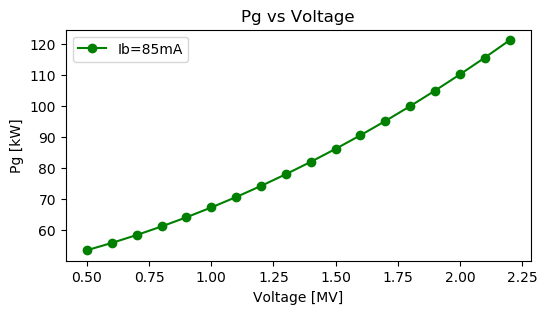

PyObject <matplotlib.legend.Legend object at 0x7fd5bf49dd10>

In [667]:
vcx = 0.5:0.1:2.2
fig=figure(figsize=(6,3))
PyPlot.plot(vcx,map(vcx->real(Pg_power(vcx*1e6,1.7e5,85e-3,phisynch,200)),vcx),"go-",label="Ib=85mA")
#PyPlot.plot(vcx,map(vcx->real(PgkW(vcx*1e6,200,2.0e10/1.7e5,85e-3)),vcx),"r-",label="Ib=85mA")
# Legend the plot
title("Pg vs Voltage")
xlabel("Voltage [MV]")
ylabel("Pg [kW]")
legend(loc="upper left")

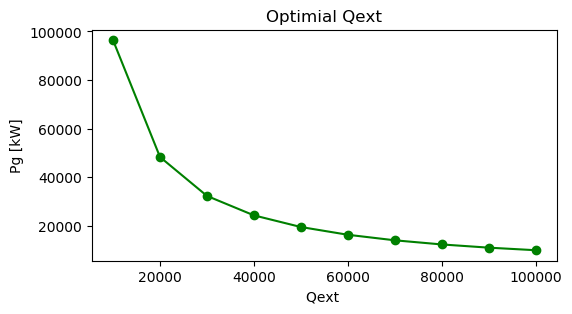

PyObject Text(24.0, 0.5, 'Pg [kW]')

In [668]:

Qextx =1e4:1e4:1e5
Vcav_inj=23.7e6
fig=figure(figsize=(6,3))
#plot(Qextx, map(Qextx->PgkW(23.7e6,200,2.0e10/Qextx,85e-3),Qextx),"d-")
PyPlot.plot(Qextx,map(Qextx->Pg_power(23.7e6,Qextx,85e-3,phisynch,200),Qextx),"go-",label="Ib=85mA")
#xscale("log")
# Legend the plot
title("Optimial Qext")
xlabel("Qext ")
ylabel("Pg [kW]")
#PgkW(23.7e6,-6.27e4,920816.4755749144,2.496)

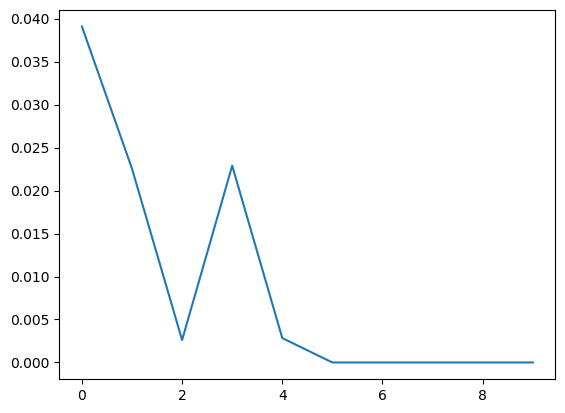

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd5d1084850>

In [669]:
#case=(Vsp_ampl,phase_sin,Ncavity,deltaf,beta,Ib0)
case5GeV0=[11.1e6 3.010 5  4.81e4 2.5e10 4.29e4 2.496]  #1
case10GeV=[23.7e6 2.966 14 6.27e4 2.5e10 2.47e4 2.496]  #1
case18GeV=[68.1e6 2.541 12 1.64e3 2.5e10 2.62e5 0.261]  #3
case5GeV1=[11.1e6 3.010 5  4.81e4 2.5e10 2.47e4 2.496]   #4
case18GeV1=[68.1e6 2.541 12 1.64e3 2.5e10 2.47e4 0.261]  #5
paraset=[case5GeV0;case10GeV;case18GeV;case5GeV1;case18GeV1]
Pg=zeros(10);a1=zeros(10);a2=zeros(10);a3=zeros(10);
for i=1:5
caseNum=i
VrfX=paraset[caseNum,1]/paraset[caseNum,3] ;QeX=paraset[caseNum,6];
IbX=paraset[caseNum,7];phisynchX=paraset[caseNum,2];deltafX=[caseNum,4]
    
ax=(Pg_power(paraset[caseNum,1]/paraset[caseNum,3],paraset[caseNum,6],paraset[caseNum,7],paraset[caseNum,2],paraset[caseNum,4]))
Pg[i]=ax[1]
#a1[i]=ax[2]
#a2[i]=ax[3]
#a3[i]=ax[4]
end

#Pg_power(VrfX,QeX,IbX,phisynchX,deltafX)
PyPlot.plot(Pg/1e6)

# Cavity

In [670]:
# Ring parameters
Crev=3834.9; frev=clight/Crev; f9MHz=frev*120; f28MHz=frev*360; T28MHz=1/f28MHz; f56MHz=frev*720
harm1=720*10; frf=f56MHz*10*Hz;dT=Crev/clight/360*1e6 # in usec

gammat=31. ; gamma0=9.785e3 ; vrf=22.0e6;phisynch=170.5*pi/180; omegarf=2*pi*frf;Trf=1/frf;
trev=Crev/clight;omega_rev=2*pi/trev;
ebeta= sqrt(1-1/gamma0^2)
eta = 1/gammat^2 - 1/gamma0^2;
r0=qe^2/me0/clight^2;
pcoeff = -1*vrf*omegarf/(0.511e6)  # this "0.511 MeV" has to change to 9.38e6 for proton
synchronous_volt= vrf*sin(phisynch)
tcoeff = trev*eta/(ebeta^2*gamma0)
rcoeff = pcoeff/tcoeff
synchrotron_tune = sqrt(-pcoeff*tcoeff)/(2*pi)
tunesexact = acos(1+pcoeff*tcoeff/2)/(2*pi)
fsyn = synchrotron_tune/trev
print("#############")
print("synchrotron_tune=",synchrotron_tune,",  fsyn=",fsyn,", frf=",frf/1e6,", eta=",eta)
# Getinput

iseed=171487 ;
aatom=1 ; qatom=1.  ; taupart=0.65e-11 ; tauhat=1.87e-10  ;
harmbtf=0.1 ; phibtf=1.
tradperp=5.e-2  ; sigperp=3.6e-4   #nominal rms transverse size
tradlong=2.5e-2 ; siglong=5.4

print("fsyn=",fsyn)
eta

#############synchrotron_tune=0.0724324071397075,  fsyn=5662.387383052925, frf=562.8584050692326, eta=0.0010405722820507415fsyn=5662.387383052925

0.0010405722820507415

In [767]:
# bunch pattern
Nbucket=315*2;Nbunch=315*2;Ngap=Nbucket-Nbunch;Nbeam_turn=10;
beamXturn=vcat(ones(Complex,Nbunch),zeros(Complex,Ngap));
currentfactor=1; m=1;modx=1;modtimes=0
for i=1:Nbeam_turn-1
    if mod(i,modx)==0
        currentfactor=1+m*modtimes
        m=m+1
    end
    append!(beamXturn,currentfactor*vcat(ones(Nbunch),zeros(Ngap)))
    i=i+1
end
length(beamXturn)

# Time span
Crev=3833.845;frev=cc/Crev; harm1=315; frf=frev*315*24  # (591 MHz)
fbunch=(frev*Nbucket); Tb=1/fbunch;dt_bunch=1/fbunch;Tbeam=2/frev;

Nwait=100;Nfall=0*Nbucket;Nfill=0;Nbeam_delay=0*Nbucket;Nflat=Nbucket*Nbeam_turn;Nturn_beamoff_early=20*Nbucket;
Nend=Nwait+Nfill+Nbeam_delay+Nflat+Nfall+Nturn_beamoff_early
Nbeam_off=Nend+1

Qb0=2*17.2*1e10*qe;Ib0=-Qb0*Nbunch*frev; 
#Ib0=-0.13550370696559326
Ib_eRHIC2=Ib0*vcat(0,zeros(Complex,Nwait+Nfill+Nbeam_delay),beamXturn,zeros(Complex,Nfall+Nturn_beamoff_early));
Qb=Ib0/(Nbunch*frev)*vcat(0,zeros(Complex,Nwait+Nfill+Nbeam_delay),beamXturn,zeros(Complex,Nfall+Nturn_beamoff_early));
#plot(Ib_eRHIC2)
length(Ib_eRHIC2),Nend,length(Qb)
#Ntinj=log(2)*Tfill/dt


(19001, 19000, 19001)

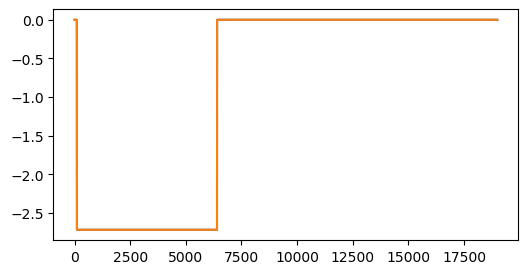

100

In [768]:
Q0=2.3e10;RoQ=146;Z0=50;Lcav=0.5352;deltaf=68149.00713820636;
Qload=2.5e4  #2.5e4;
fres=frf-deltaf #predetune in Hz
rho=RoQ/2; # (rho is the half of Rshunt/Qo, i.e circuit definition)
Rsh=Q0*RoQ;R=Rsh/2;wo=2*pi*fres;Tfill=2*Qload/wo;w12=wo/(2Qload);Rload=rho*Qload; #( Rload is circuit definition)
#n_coupler=sqrt(R/Z0*Qload/(Q0-Qload));
beta_coupler=Q0/Qload-1;dUdt=zeros(Nend);n_coupler=sqrt(R/beta_coupler/Z0);tanPsi=Q0/(1+beta_coupler)*(fres/frf-frf/fres)

dt=dt_bunch;Tend=(Nend)*dt;Tsim=0:dt:Tend; Ntgrid=length(Tsim);
#dt=10/frf;Tend=60*Tfill;Tsim=0:dt:Tend; Ntgrid=length(Tsim);
Nwait=Nwait;Nfall=Nfall;
Nbeam_in=Nwait+Nfill+Nbeam_delay;Nbeam_on=Nbunch;Nbeam_gap=Ngap
#Nbeam_in=Int(floor(8.0Tfill/dt));Nbeam_on=Int(floor(10.0Tfill/dt));Nbeam_gap=Int(floor(10.0Tfill/dt))
Nfb=Nwait+0

#Qb0=17.2*1e10*qe;Ib0=Qb0*Nbunch*frev; 
#Ib0=-0.13550370696559326
Ibx=1*Ib0*vcat(0,zeros(Nwait+Nfill+Nbeam_delay),beamXturn,zeros(Complex,Nfall+Nturn_beamoff_early));
#plot(Ibx)
fig=figure(figsize=(6,3))
PyPlot.plot(Ibx)
PyPlot.plot(Ib_eRHIC2)
Nbeam_in

In [769]:
#Ib=vcat(zeros(Nbeam_in),Ib0*ones(Complex,Ntgrid-Nbeam_in))
#Ib=Ibx
vrf=23.7e6/14;phisynch=170*pi/180
synchronous_volt= vrf*sin(phisynch)

sp_ampl=synchronous_volt/sin(phisynch);sp_phase=(pi/2-(pi-phisynch))*180/pi*deg;
set_Volt=sp_ampl #*exp(1im*(sp_phase)*pi/180)

if sp_phase==0
  Ix=0
else
  Ix=(deltaf/(w12/2/pi))/(RoQ*Q0*sin(pi/180*sp_phase)/sp_ampl/(1+beta_coupler))
end

function Pg_power(currentfactor)
  a1=sp_ampl^2/4/RoQ/Q0*(beta_coupler+1)^2/beta_coupler;
  a2=(1+RoQ*Q0*(Ib0*currentfactor)*cos(pi/180*sp_phase)/sp_ampl/(1+beta_coupler))^2;
  a3=((fres-frf)*currentfactor/(w12/2/pi)+RoQ*Q0*(Ib0*currentfactor)*sin(pi/180*sp_phase)/sp_ampl/(1+beta_coupler))^2;
  Pg=a1*(a2+a3)/1e6;
  return Pg,a1,a2,a3
end
Pg=Pg_power(1)
#Pb_ideal=sp_ampl*sin(pi/180*sp_phase)*Ib0, Ix
df_a3=RoQ*Q0*(Ib0*currentfactor)*sin(pi/180*sp_phase)/sp_ampl/(1+beta_coupler)*(w12/2/pi)
println("Pg=",Pg)
println("df_a3= ",df_a3,", set_Volt=",set_Volt*cos((90-sp_phase)*pi/180)/1e6)
sp_ampl*exp(1im*(sp_phase)*pi/180)/1e6


Pg=(26.091103060461794, 196285.50829370716, 0.00027094295400174764, 132.92397439369608)
df_a3= -68149.008950151, set_Volt=1.6671388390278097


0.29396155790758866 + 1.6671388390278097im

In [770]:
Ib0*sp_ampl*cos(sp_phase*pi/180)/1e6
#sp_phase
Pg[1]

26.091103060461794

In [771]:
0.19628550829370717*4

0.7851420331748287

# formula=>plots


In [772]:
pbeam_abs=Ib0*sp_ampl*cos(sp_phase*pi/180)
Ig_abs=sqrt(2*beta_coupler*abs(pbeam_abs)/R)
println(pbeam_abs/1e6, "   ", Ig_abs," ", Ib0)
set_Ic=sp_ampl/(Rload*cos(atan(tanPsi)))
Vg1=2*Rload*Ig_abs*cos(atan(tanPsi));
Vb1=2*Rload*abs(Ib0)*cos(atan(tanPsi));
Vc1=sp_ampl;
acos((Vg1^2+Vb1^2-Vc1^2)/(2*Vg1*Vb1))
#println(Ig_abs^2*Rload/2/1e6," ", Ib0*Vb1/1e6)
println(Vg1/1e6,"  ",Vb1/1e6, "  ", acos((Vg1^2+Vb1^2-Vc1^2)/(2*Vg1*Vb1)))

println(set_Ic,"  ", Ig_abs, "  ", Ib0, "  ",2*(Ig_abs+Ib0) )
Icx=1/(1+beta_coupler)*(1-1im*(1+beta_coupler)*tanPsi)/(1-1im*tanPsi)*(2Ig_abs+2*Ib0)

-0.7980648743682387   0.935195537040348 -2.714861358229441
0.583458330518345  1.6937724924076236  1.3961044168431007
5.426788382438214  0.935195537040348  -2.714861358229441  -3.5593316423781864


-3.4553403218042162 - 0.5994372367239597im

In [773]:
Vgr=2*sqrt(beta_coupler)*sqrt(2R*abs(pbeam_abs))/(1+beta_coupler)
Vbr=2*Ib0*Rload

Vc=Rload*(set_Ic)/cos(atan(tanPsi))/1e6

(Vg1*cos(2.14)+Vb1)/1e6



1.3793109449272372

In [774]:
#1 case: static states
t=(0:dt:Ntgrid*dt)
fig=figure(figsize=(6,3))
#function plotTry(x)
# Filling
Vg_abs(t)=Rload*2*Ig_abs*(1-exp(-(1-1im*tanPsi*1)*t/Tfill))/(1-1im*tanPsi*1)*cos(0.09943226768250287)
Vg_abs_filling=map(t->Vg_abs(t),t)
#plot(Vg_abs_filling/(Rload*cos(atan(tanPsi))),label="Ic_filling")
PyPlot.plot(t*1e6,(Vg_abs_filling)/1e6,"k",label="Ig_filling")
title("Filling a detuned cavity")
xlabel("T (us)")
ylabel("Voltage (MV)")
legend()
function Vb_abs(t)
    tinj=Nbeam_in*dt
    if t>=tinj
        return Rload*2*Ib0*(1-exp(-(1-1im*tanPsi)*(t-tinj)/Tfill))/(1-1im*tanPsi)
    else
        return 0
    end
end
Vb_abs2=map(t->Vb_abs(t),t);
#plot(Vb_abs2/(Rload*cos(atan(tanPsi))),label="Ib0_filling")
#PyPlot.plot((Vb_abs2)/1e6,label="Ib0_filling")
#PyPlot.plot((Vb_abs2.+Vg_abs_filling)/1e6,"r",label="sum")
xlim(0,200)
#PyPlot.plot(Ib)
legend()
#return (Vb_abs2.+Vg_abs_filling)/1e6
    
#end
println(abs((Vb_abs2.+Vg_abs_filling)[20000])/1e6,"  ",angle((Vb_abs2.+Vg_abs_filling)[20000])*180/pi-90)

#x=0:0.1:pi/10
#plot(x,map(x->plotTry(x),x))


BoundsError: BoundsError: attempt to access 19002-element Array{Complex{Float64},1} at index [20000]

In [775]:
Igfill=set_Volt/Rload/2 

Pow_max=abs(Ib0*sp_ampl*cos(sp_phase*pi/180))
Pow_max=maximum([abs(Ib0*sp_ampl*cos(sp_phase*pi/180)),Pg[1]])

798064.8743682387

In [776]:
# ceated mechanical model
mech_fm=[50 30 100];mech_Qm=[100 100 100];mech_Km=[0.4 0.3 0.2]*1e-12;mech_DW=zeros(3,Ntgrid);
mech_dDWdt=zeros(3,Ntgrid);mech_time=0;mech_wave=0;mech_uphonics=0 ;#+/- Hz detuning due to microphonics
mech_wm=2*pi*mech_fm;
mech_uphonics=30 ;#+/- Hz detuning due to microphonics
min(abs(mech_wm[1]),abs(mech_uphonics))


30.0

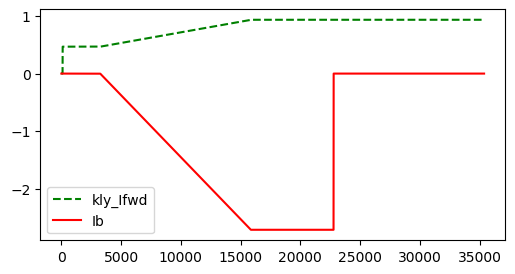

0.0007051077461812105 + 0.0im

In [935]:
# current ramp
N_fill_add=5Nbucket;Nramp=20Nbucket;Nramp_total=N_fill_add+Nramp;Npulse_delay=1*Nbucket
Ib_ramp=zeros(Complex,Nramp_total);df_ramp=zeros(Complex,Nramp_total);Ig_ramp=zeros(Complex,Nramp_total);

#Pow_max=maximum([abs(Ib0*sp_ampl*cos(sp_phase*pi/180)),Pg[1]*1e6]);  # if Ib=0
Pow_max=abs(Ib0*sp_ampl*cos(sp_phase*pi/180));
Ikly0=sqrt(Pow_max*2/Z0)/n_coupler
Igfill=sqrt(Pow_max/4*2/Z0)/n_coupler #

pbeam_abs=Ib0*sp_ampl*cos(sp_phase*pi/180)
#Ig_abs=maximum([sqrt(2*beta_coupler*abs(pbeam_abs)/R),Ikly0])  # if Ib=0
Ig_abs=sqrt(2*beta_coupler*abs(pbeam_abs)/R)

deltaW0=2pi*real(deltaf)

for i=1:Nramp_total
    if i<=N_fill_add
      Ib_ramp[i]=0*Ib0/Nbucket
      df_ramp[i]=0*deltaW0/Nbucket
      Ig_ramp[i]=Igfill
    else
      Ib_ramp[i]=(i-N_fill_add)*Ib0/(Nramp_total-N_fill_add)
      df_ramp[i]=(i-N_fill_add)*deltaW0/(Nramp_total-N_fill_add)
      Ig_ramp[i]=Igfill+1*(i-N_fill_add)*(Ig_abs-Igfill)/(Nramp_total-N_fill_add)
    end
end

Ntgrid_ramp=Ntgrid+Nramp_total+Npulse_delay
#


kly_Pfor=zeros(Complex,Ntgrid_ramp);
kly_Pref=zeros(Complex,Ntgrid_ramp);
dUdt2=zeros(Ntgrid_ramp);dUdt=zeros(Ntgrid_ramp);
DT_sim=dt;
Itotal_sim=zeros(Complex,Ntgrid_ramp);Vc_sim=set_Volt*zeros(Complex,Ntgrid_ramp);
Vwg_for=zeros(Complex,Ntgrid_ramp);Vwg_ref=zeros(Complex,Ntgrid_ramp);
Vg=zeros(Complex,Ntgrid_ramp);Vb=zeros(Complex,Ntgrid_ramp)
Ref_wg=zeros(Complex,Ntgrid_ramp);
Icav_sim=zeros(Complex,Ntgrid_ramp); Pbeam=zeros(Complex,Ntgrid_ramp);
Vb=zeros(Complex,Ntgrid_ramp);Vg=zeros(Complex,Ntgrid_ramp); 
Isp_sim=zeros(Complex,Ntgrid_ramp);Icav_sim=zeros(Complex,Ntgrid_ramp);
err_sim=zeros(Complex,Ntgrid_ramp);err_phase=zeros(Complex,Ntgrid_ramp);  Vsp_sim=zeros(Complex,Ntgrid_ramp)

# generate Ib, kly_Ifwd, deltaW profile
Ib=1*vcat(0,zeros(Nwait),Ib_ramp,Ib0*ones(Complex,Npulse_delay),Ib0*beamXturn.+0*1im,zeros(Complex,Nfall+Nturn_beamoff_early));
#kly_Ifwd=0*vcat(0,zeros(Nwait),Ig_ramp,Igfill*ones(length(beamXturn)),zeros(Nfall+Nturn_beamoff_early));
kly_Ifwd=1*vcat(0,zeros(Nwait),Ig_ramp,Ikly0*ones(Npulse_delay),Ikly0*ones(length(beamXturn)),1*Ikly0*ones(Nfall+Nturn_beamoff_early));

deltaW=1.5*vcat(0,zeros(Complex,Nwait),df_ramp,deltaW0*ones(Complex,Npulse_delay),deltaW0*ones(Complex,length(beamXturn)),deltaW0*ones(Nfall+Nturn_beamoff_early));

detune_sim=deltaW;  kly_Ifwd_new=zeros(Complex,Ntgrid_ramp)
#PyPlot.plot(deltaW)
Ttotal=0:dt:dt*(Ntgrid_ramp-1)
length(Ttotal)-Ntgrid_ramp
Pfd=0.5*Rload*kly_Ifwd.^2

fig=figure(figsize=(6,3))
PyPlot.plot(kly_Ifwd,"g--",label="kly_Ifwd")
#PyPlot.plot(deltaW/2pi/1e6,"ko",label="deltaW")
PyPlot.plot(Ib,"r-",label="Ib")
legend()
length(Ib)-Ntgrid_ramp
#xlim(0,Nwait+Nfill)
kly_Ifwd[Nwait+N_fill_add+20]-kly_Ifwd[Nwait+N_fill_add+1]


In [936]:
deltaW[10000]

344032.557085693 + 0.0im

In [937]:
# Coupling
dir_BeamOn=1; dir_LFD=0;dir_track=1;dir_FB=1;wakeON=0;Rad_on=0

Vsp_sim=set_Volt

#Feedback setting  For CW: kly_phase=-0.202
klyGain_dB=0;kly_gain=10^(klyGain_dB/20);          kly_phase=(90-10.350)*pi/180# +0.8752052;
Kp_sim=20.1000;Ki_sim=1.;sysgain=1;FB_i=0;FB_p=0;FB_corr=0
ph_corr=0;ph_p=0;ph_i=0; FB_corr1=zeros(Complex,Ntgrid_ramp)

for nx=2:Ntgrid_ramp
    fres=real(frf-detune_sim[nx-1]/2/pi)
    tanPsi=Q0/(1+beta_coupler)*(fres/frf-frf/fres)
    Isp_sim[nx] = set_Volt/(Rload*cos(atan(tanPsi)))
    Icav_sim[nx-1]=Vc_sim[nx-1]/(Rload*cos(atan(tanPsi)))
    kly_Ifwd_new[nx]=kly_Ifwd[nx]*exp(1im*kly_phase)
    Vg[nx]=Rload*2*kly_Ifwd_new[nx]*(1-exp(-w12*nx*DT_sim))*cos(atan(tanPsi))*exp(1im*atan(tanPsi)) 
    
    Itotal_sim[nx]=2*kly_Ifwd_new[nx]+2*Ib[nx]*dir_BeamOn # *dir_BeamOn # Here I use kly_ifwd are positive, Ib is positive,
  
    
    
 if nx> Nwait
    Vb[nx]=Rload*2*Ib[nx]*(1-exp(-w12*(nx-Nwait-N_fill_add)*DT_sim))*cos(atan(tanPsi))*exp(1im*atan(tanPsi))        
  end 
   # compute cavity voltage
  # Vc_sim[nx]=(Vc_sim[nx-1]+0.5*DT_sim*rho*wo*Itotal_sim[nx])/(1+DT_sim*(w12-1im*deltaW[nx]))   # seen in the cavity side
   Vc_sim[nx]=(Vc_sim[nx-1]+1*DT_sim*Rload*w12*Itotal_sim[nx])/(1+DT_sim*(w12+1im*real(deltaW[nx])))
    #  kly_Pref[nx]=kly_Pfor[nx]-dUdt[nx]-Pbeam[nx]
     # store total detuning
   detune_sim[nx]=deltaW[nx]  #in rad
    
       
   kly_Pfor[nx]=0.5*Rload*abs(kly_Ifwd_new[nx])^2
   
    
   Vwg_for[nx]=sqrt(kly_Pfor[nx]*2*Z0)
    
   dUdt2[nx]=abs(Vc_sim[nx])^2/RoQ/Q0
   dUdt[nx]=2*(real(Vc_sim[nx])*(real(Vc_sim[nx])-real(Vc_sim[nx-1]))+ imag(Vc_sim[nx])*(imag(Vc_sim[nx])-imag(Vc_sim[nx-1])))/(wo*RoQ*DT_sim)
 # 
    
#   kly_Pref2[nx]=(kly_Ifwd[nx]*n_coupler-Vc_sim[nx]/(n_coupler*Z0))^2*Z0/2
    
   Vwg_ref[nx]= Vc_sim[nx]/n_coupler-Vwg_for[nx]
 #    
   if real(Vwg_for[nx])>0
        Ref_wg[nx]= Vwg_ref[nx]/Vwg_for[nx]
   end
  if nx> Nwait && dir_BeamOn==1
    Pbeam[nx]=abs(Vc_sim[nx])*abs(Ib[nx])*cos(angle(Vc_sim[nx]))  
             
   end
    
      kly_Pref[nx]=(kly_Pfor[nx]-(dUdt[nx])-(Pbeam[nx]))

end

#save("/Users/wxu/Desktop/juliaDataSave/setup.jld","detuningfreq",detuningfreq,"Ib",Ib,"kly_Pfwd",kly_Pfwd,"Qb",Qb)

#d=load("/Users/wxu/Desktop/juliaDataSave/setup.jld","detuningfreq")
#Vc_sim[5000:5010]/1e6
nXX=Nwait+Nramp_total+length(beamXturn)-2*(Nbucket-2Ngap)
println("set_volt=",set_Volt/1e6," Vc_sim_abs=",abs(Vc_sim[nXX])/1e6)
println("Vc_sim=",Vc_sim[nXX]/1e6)
println(" phase= ",(angle(-Ib[nXX])+angle(Vc_sim[nXX]))*180/pi,", kly_phase=",kly_phase*180/pi)
println("Pbeam=",(Pbeam[nXX])/1e6," Ibeam0=",Ib0)
println("Pref=", kly_Pref[nXX]/1e6)
println("Pfor=", kly_Pfor[nXX]/1e6)
println("dUdt=", dUdt[nXX]/1e6)
sp_ampl*exp(1im*(sp_phase)*pi/180)/1e6
println("Vg+Vb=",(Vg[nXX]+Vb[nXX])/1e6)

set_volt=1.692857142857143 Vc_sim_abs=1.1354790236821743
Vc_sim=0.26052352307725035 + 1.1051878153262644im
 phase= 76.73593619256299, kly_phase=79.65
Pbeam=0.7072852457122228 + 0.0im Ibeam0=-2.714861358229441
Pref=0.09077855116281915 + 0.0im
Pfor=0.7980640069064189 + 0.0im
dUdt=2.1003137675418993e-7
Vg+Vb=0.2605273612806138 + 1.1052199832370542im


0.1680179302656816   0.3913158310235714

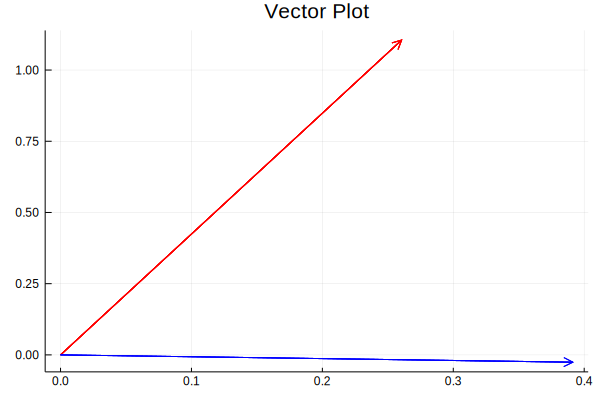

In [938]:
#The ith vector extends from (x[i],y[i]) to (x[i] + u[i], y[i] + v[i]).
fig=figure(figsize=(6,6))
nXX2=Nwait+Nramp_total+length(beamXturn)-2*Nbucket
T_stamp=nXX2

x0 = [0,0,0,0];y0=[0,0,0,0];
u0 = [real(Itotal_sim[T_stamp])];
v0 = [imag(Itotal_sim[T_stamp])];
p1=Plots.quiver(x0,y0,quiver=(u0,v0),color="black",label=["Vc_sim"],title="Vector Plot")
Plots.plot(p1)#,label=["Vc_sim"])

x0 = [0,0,0,0];y0=[0,0,0,0];
u0 = [real(Vc_sim[T_stamp]/1e6)];
v0 = [imag(Vc_sim[T_stamp]/1e6)];
p1=Plots.quiver(x0,y0,quiver=(u0,v0),color="red",label=["Vc_sim"],title="Vector Plot")
Plots.plot(p1)#,label=["Vc_sim"])

x1 = [0,0];y1=[0,0];
u1 = [real(Vg[T_stamp]*1/1e6)];
v1 = [imag(Vg[T_stamp]*1/1e6)];
print(real(kly_Ifwd_new[T_stamp]),"   ",real(Vg[T_stamp]*1/1e6))
p2=Plots.quiver!(x1,y1,quiver=(u1,v1),color="blue",label=["Vc_sim"])
Plots.plot(p2)#,label=["Vg"])

0.1680179302656816   0.3913158310235714

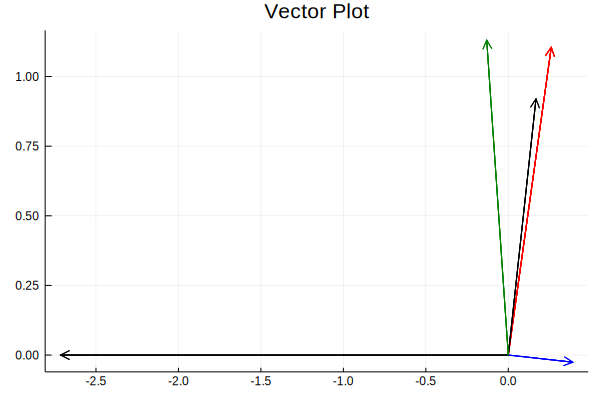

In [939]:
#The ith vector extends from (x[i],y[i]) to (x[i] + u[i], y[i] + v[i]).
fig=figure(figsize=(6,6))
x1 = [0,0];y1=[0,0];
u1 = [real(kly_Ifwd_new[T_stamp])];
v1 = [imag(kly_Ifwd_new[T_stamp])];

print(real(kly_Ifwd_new[T_stamp]),"   ",real(Vg[T_stamp]*1/1e6))
p2=Plots.quiver!(x1,y1,quiver=(u1,v1),color="black",label=["Vc_sim"])
Plots.plot(p2)#,label=["Vc","Vg","Ig"])

#The ith vector extends from (x[i],y[i]) to (x[i] + u[i], y[i] + v[i]).
fig=figure(figsize=(6,6))

x2 = [0,0];y2=[0,0];
u2 = [real(Ib[T_stamp])];
v2 = [imag(Ib[T_stamp])];
p3=Plots.quiver!(x2,y2,quiver=(u2,v2),color="black",label=["Vc_sim"])
x2 = [0,0];y2=[0,0];
u2 = [real(Vb[T_stamp]/1e6)];
v2 = [imag(Vb[T_stamp]/1e6)];
p3=Plots.quiver!(x2,y2,quiver=(u2,v2),color="green",label=["Vc_sim"])
Plots.plot(p3)#,label=["Vc","Ig,Vg","Ib,Vb"])

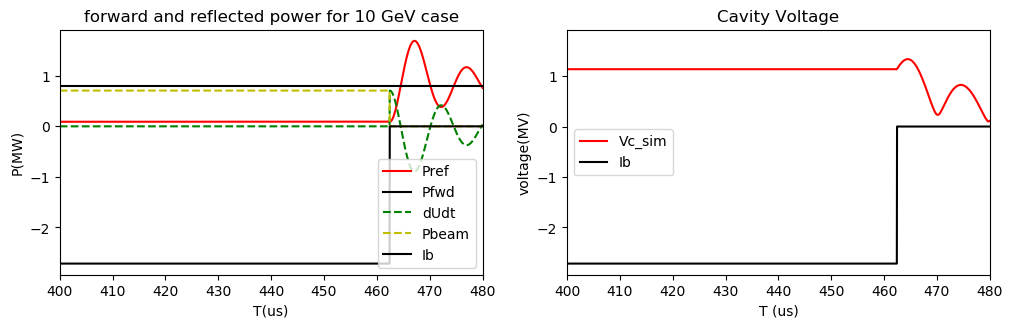

PyObject Text(531.2727272727273, 0.5, 'voltage(MV)')

In [940]:
fig=figure(figsize=(12,7))
subplot(221)
PyPlot.plot(Ttotal*1e6,(kly_Pref)/1e6,"r-",label="Pref")
PyPlot.plot(Ttotal*1e6,kly_Pfor/1e6,"k-",label="Pfwd")
#PyPlot.plot(Ttotal*1e6,2*kly_Pfor/1e6,"k--",label="2*Pfwd")
PyPlot.plot(Ttotal*1e6,(dUdt)/1e6,"g--",label="dUdt")
PyPlot.plot(Ttotal*1e6,Pbeam/1e6,"y--",label="Pbeam")
PyPlot.plot(Ttotal*1e6,(Ib),"k",label="Ib")
xlim(400,480)
legend()
title("forward and reflected power for 10 GeV case")
#PyPlot.plot(Ttotal*1e6,Ib,"g")
#xlim((Nwait+Nramp)*DT_sim*1e6,(Nwait+Nramp+10Nbucket)*DT_sim*1e6)
#ylim(-20,20)
xlabel("T(us)")
ylabel("P(MW)")


subplot(222)
PyPlot.plot(Ttotal*1e6,abs.(Vc_sim)/1e6,"r",label="Vc_sim")
PyPlot.plot(Ttotal*1e6,(Ib),"k",label="Ib")
legend()
title("Cavity Voltage")
#PyPlot.plot((Vsp_sim)/1e6)
xlim(400,480)
xlabel("T (us)")
ylabel("voltage(MV)")


#PyPlot.plot(Ttotal*1e6,(angle.(-Ib)+angle.(Vc_sim))*180/pi,"k",label="Phase of Vc_sim")
#legend()
#xlim(1500,1850)



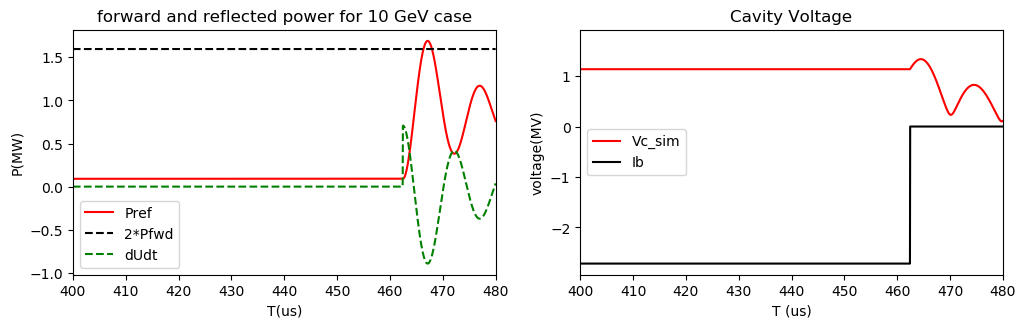

PyObject Text(544.3977272727273, 0.5, 'voltage(MV)')

In [941]:
fig=figure(figsize=(12,7))
subplot(221)
PyPlot.plot(Ttotal*1e6,(kly_Pref)/1e6,"r-",label="Pref")
#PyPlot.plot(Ttotal*1e6,kly_Pfor/1e6,"k-",label="Pfwd")
PyPlot.plot(Ttotal*1e6,2*kly_Pfor/1e6,"k--",label="2*Pfwd")
PyPlot.plot(Ttotal*1e6,(dUdt)/1e6,"g--",label="dUdt")
#PyPlot.plot(Ttotal*1e6,Pbeam/1e6,"y--",label="Pbeam")
xlim(400,480)
legend()
title("forward and reflected power for 10 GeV case")
#PyPlot.plot(Ttotal*1e6,Ib,"g")
#xlim((Nwait+Nramp)*DT_sim*1e6,(Nwait+Nramp+10Nbucket)*DT_sim*1e6)
#ylim(-20,20)
xlabel("T(us)")
ylabel("P(MW)")


subplot(222)
PyPlot.plot(Ttotal*1e6,abs.(Vc_sim)/1e6,"r",label="Vc_sim")
PyPlot.plot(Ttotal*1e6,(Ib),"k",label="Ib")
legend()
title("Cavity Voltage")
#PyPlot.plot((Vsp_sim)/1e6)
xlim(400,480)
xlabel("T (us)")
ylabel("voltage(MV)")


#PyPlot.plot(Ttotal*1e6,(angle.(-Ib)+angle.(Vc_sim))*180/pi,"k",label="Phase of Vc_sim")
#legend()
#xlim(1500,1850)



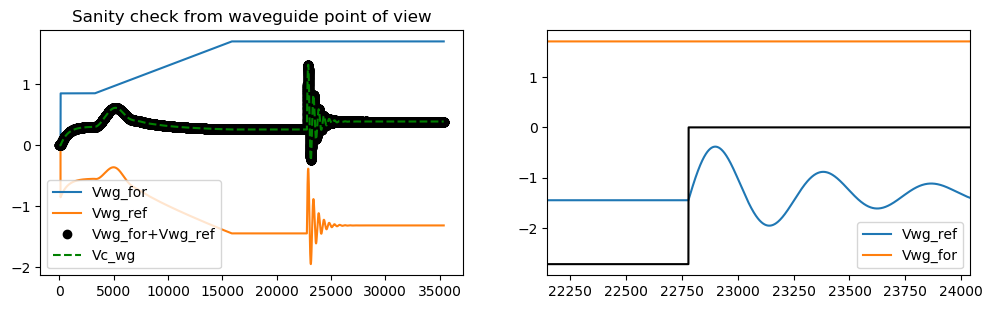

PyObject <matplotlib.legend.Legend object at 0x7fd513b33f50>

In [942]:
fig=figure(figsize=(12,7))
subplot(221)
# sanity check
nXX=Nwait+Nramp_total+length(beamXturn)
PyPlot.plot(Vwg_for*n_coupler/1e6,label="Vwg_for")
PyPlot.plot(Vwg_ref*n_coupler/1e6,label="Vwg_ref")
PyPlot.plot((Vwg_ref+Vwg_for)*n_coupler/1e6,"ko",label="Vwg_for+Vwg_ref")
PyPlot.plot(Vc_sim/1e6,"g--",label="Vc_wg")

legend()
title("Sanity check from waveguide point of view")
subplot(222)
PyPlot.plot(Vwg_ref*n_coupler/1e6,label="Vwg_ref")
PyPlot.plot(Vwg_for*n_coupler/1e6,label="Vwg_for")
PyPlot.plot(Ib,"k-")
xlim(nXX,nXX+3Nbucket)
legend()

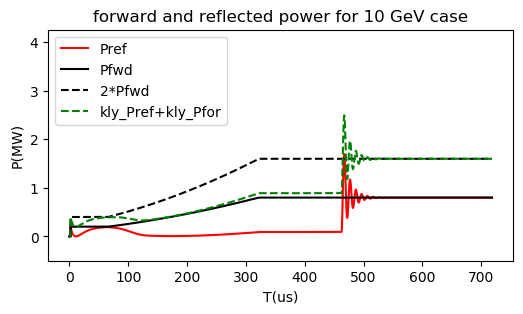

PyObject Text(24.000000000000007, 0.5, 'P(MW)')

In [943]:
fig=figure(figsize=(6,3))
PyPlot.plot(Ttotal*1e6,kly_Pref/1e6,"r",label="Pref")
PyPlot.plot(Ttotal*1e6,kly_Pfor/1e6,"k",label="Pfwd")
PyPlot.plot(Ttotal*1e6,2*kly_Pfor/1e6,"k--",label="2*Pfwd")
PyPlot.plot(Ttotal*1e6,(1*kly_Pref .+1*kly_Pfor)/1e6,"g--",label="kly_Pref+kly_Pfor")
#PyPlot.plot(Ttotal*1e6,-Ib,"y",label="Ib")
legend()
title("forward and reflected power for 10 GeV case")
#PyPlot.plot(Ttotal*1e6,Ib,"g")
#xlim(1080,1900)
ylim(-0.5,4.25)
xlabel("T(us)")
ylabel("P(MW)")

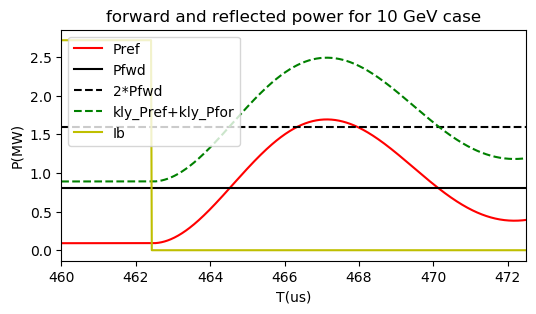

PyObject Text(24.000000000000007, 0.5, 'P(MW)')

In [951]:
fig=figure(figsize=(6,3))
PyPlot.plot(Ttotal*1e6,kly_Pref/1e6,"r",label="Pref")
PyPlot.plot(Ttotal*1e6,kly_Pfor/1e6,"k",label="Pfwd")
PyPlot.plot(Ttotal*1e6,2*kly_Pfor/1e6,"k--",label="2*Pfwd")
PyPlot.plot(Ttotal*1e6,(1*kly_Pref .+1*kly_Pfor)/1e6,"g--",label="kly_Pref+kly_Pfor")
PyPlot.plot(Ttotal*1e6,-Ib,"y",label="Ib")
legend()
title("forward and reflected power for 10 GeV case")
#PyPlot.plot(Ttotal*1e6,Ib,"g")
xlim(460,472.5)
#ylim(-0.5,4.25)
xlabel("T(us)")
ylabel("P(MW)")

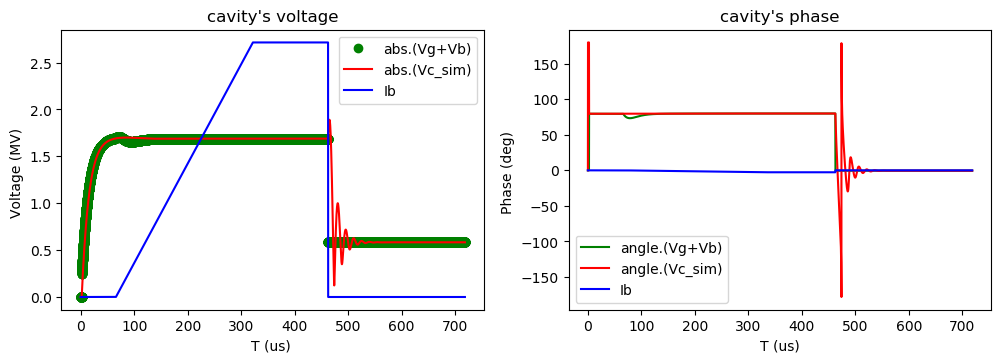

PyObject <matplotlib.legend.Legend object at 0x7fd589ca62d0>

In [861]:
#PyPlot.plot(Vg/1e6,"b")
#PyPlot.plot(Vb/1e6,"g")
fig=figure(figsize=(12,8))
subplot(221)
PyPlot.plot(Ttotal*1e6,abs.(Vg+Vb)/1e6,"go",label="abs.(Vg+Vb)")
PyPlot.plot(Ttotal*1e6,abs.(Vc_sim)/1e6,"r-",label="abs.(Vc_sim)")
PyPlot.plot(Ttotal*1e6,abs.(Ib),"b-",label="Ib")

title("cavity's voltage")
xlabel("T (us) ")
ylabel("Voltage (MV) ")
#xlim(1798,1815)
legend()
subplot(222)
PyPlot.plot(Ttotal*1e6,angle.(Vg+Vb)*180/pi,"g",label="angle.(Vg+Vb)")
PyPlot.plot(Ttotal*1e6,(angle.(-Ib)+angle.(Vc_sim))*180/pi,"r",label="angle.(Vc_sim)")
PyPlot.plot(Ttotal*1e6,real.(Ib),"b-",label="Ib")

xlabel("T (us)")
ylabel("Phase (deg) ")
title("cavity's phase")
legend()

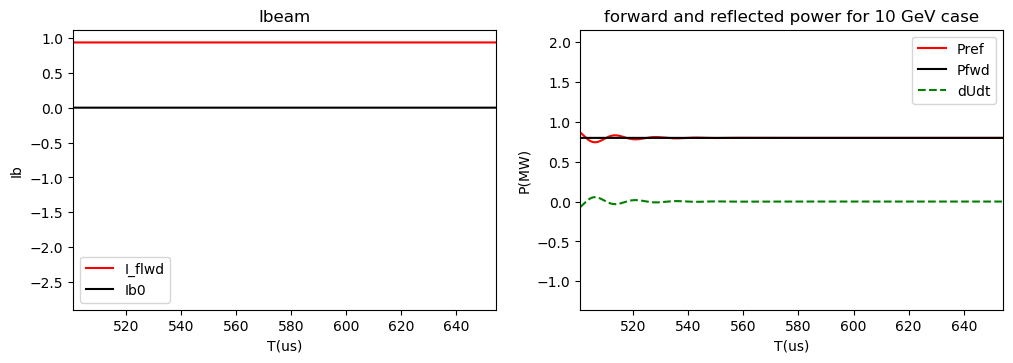

PyObject Text(531.3977272727273, 0.5, 'P(MW)')

In [863]:
#plot(power)
fig=figure(figsize=(12,8))
subplot(221)
PyPlot.plot(Ttotal*1e6,kly_Ifwd,"r",label="I_flwd")
PyPlot.plot(Ttotal*1e6,Ib,"k",label="Ib0")
xlim((Ntgrid_ramp-17Nbucket)*DT_sim*1e6,(Ntgrid_ramp-5Nbucket)*DT_sim*1e6)
title("Ibeam")
xlabel("T(us)")
ylabel("Ib")
legend()
subplot(222)
PyPlot.plot(Ttotal*1e6,kly_Pref/1e6,"r",label="Pref")
PyPlot.plot(Ttotal*1e6,kly_Pfor/1e6,"k",label="Pfwd")
PyPlot.plot(Ttotal*1e6,dUdt/1e6,"g--",label="dUdt")
#PyPlot.plot(Ttotal*1e6,Ib,"y",label="Ib")
legend()
title("forward and reflected power for 10 GeV case")
#PyPlot.plot(Ttotal*1e6,Ib,"g")
xlim((Ntgrid_ramp-17Nbucket)*DT_sim*1e6,(Ntgrid_ramp-5Nbucket)*DT_sim*1e6)
xlabel("T(us)")
ylabel("P(MW)")

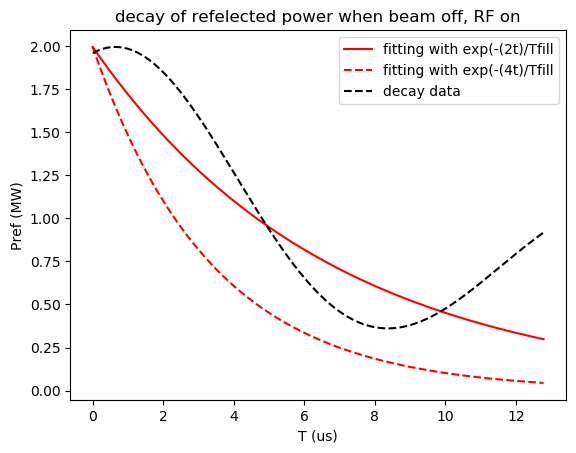

PyObject <matplotlib.legend.Legend object at 0x7fd52b63a3d0>

In [880]:
nXX=Nwait+Nramp_total+length(beamXturn)+Nbucket+300
Pref_catch=kly_Pref[nXX:nXX+Nbucket]/1e6
t_catch=0:dt:dt*(length(Pref_catch)-1)
Pref_fit(t)=maximum(real.(Pref_catch))*(exp(-(t)/Tfill))

PyPlot.plot(t_catch*1e6,map(t->Pref_fit(2t),t_catch),"r-",label="fitting with exp(-(2t)/Tfill")
PyPlot.plot(t_catch*1e6,map(t->Pref_fit(4t),t_catch),"r--",label="fitting with exp(-(4t)/Tfill")
PyPlot.plot(t_catch*1e6,Pref_catch,"k--",label="decay data")
title("decay of refelected power when beam off, RF on")
xlabel("T (us)")
ylabel("Pref (MW)")
legend()

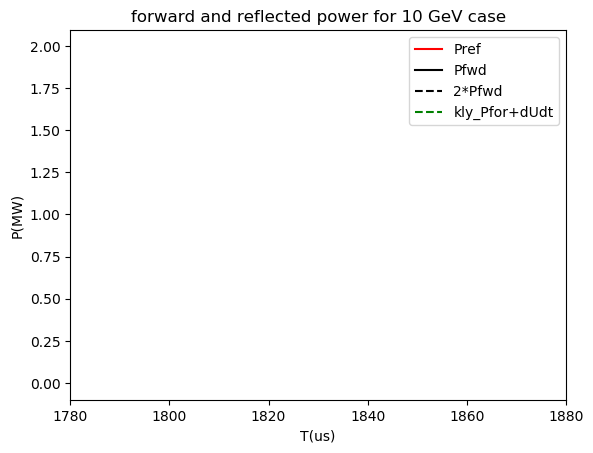

PyObject Text(24.000000000000007, 0.5, 'P(MW)')

In [796]:
PyPlot.plot(Ttotal*1e6,kly_Pref/1e6,"r",label="Pref")
PyPlot.plot(Ttotal*1e6,kly_Pfor/1e6,"k",label="Pfwd")
PyPlot.plot(Ttotal*1e6,2*kly_Pfor/1e6,"k--",label="2*Pfwd")
PyPlot.plot(Ttotal*1e6,(kly_Pfor.-dUdt)/1e6,"g--",label="kly_Pfor+dUdt")
#PyPlot.plot(Ttotal*1e6,Ib,"y",label="Ib")
legend()
title("forward and reflected power for 10 GeV case")
#PyPlot.plot(Ttotal*1e6,Ib,"g")
xlim(1780,1880)
xlabel("T(us)")
ylabel("P(MW)")

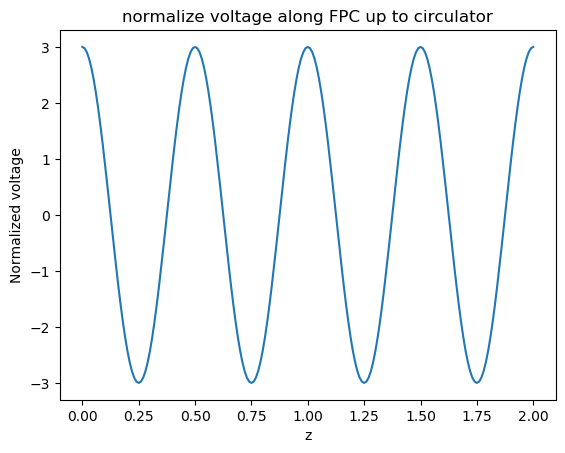

PyObject Text(24.000000000000007, 0.5, 'Normalized voltage')

In [701]:
v(z)=2exp(1im*2pi/0.5*z)+exp(-1im*2pi/0.5*z)
z=0:0.01:2
PyPlot.plot(z,map(z->v(z),z))
title("normalize voltage along FPC up to circulator")
xlabel("z")
ylabel("Normalized voltage")

In [702]:
sqrt(9*400e3*50)/1e3

13.416407864998739